In [46]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams.update({'font.size': 22})

In [47]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [48]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [49]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [50]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          652 non-null    object 
 1   Daily Confirmed                               652 non-null    int64  
 2   False Positives Found                         543 non-null    float64
 3   Cumulative Confirmed                          652 non-null    int64  
 4   Daily Discharged                              652 non-null    int64  
 5   Passed but not due to COVID                   652 non-null    int64  
 6   Cumulative Discharged                         652 non-null    int64  
 7   Discharged to Isolation                       652 non-null    int64  
 8   Still Hospitalised                            652 non-null    int64  
 9   Daily Deaths                                  652 non-null    int

In [52]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [53]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [54]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)
#sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1)

In [55]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0]) if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0]) if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [56]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [57]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [58]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               652 non-null    int64  
 1   False Positives Found                         652 non-null    float64
 2   Cumulative Confirmed                          652 non-null    int64  
 3   Daily Discharged                              652 non-null    int64  
 4   Passed but not due to COVID                   652 non-null    int64  
 5   Cumulative Discharged                         652 non-null    int64  
 6   Discharged to Isolation                       652 non-null    int64  
 7   Still Hospitalised                            652 non-null    int64  
 8   Daily Deaths                                  652 non-null    int64  
 9   Cumulative Deaths                             652 non-null    int

<AxesSubplot:>

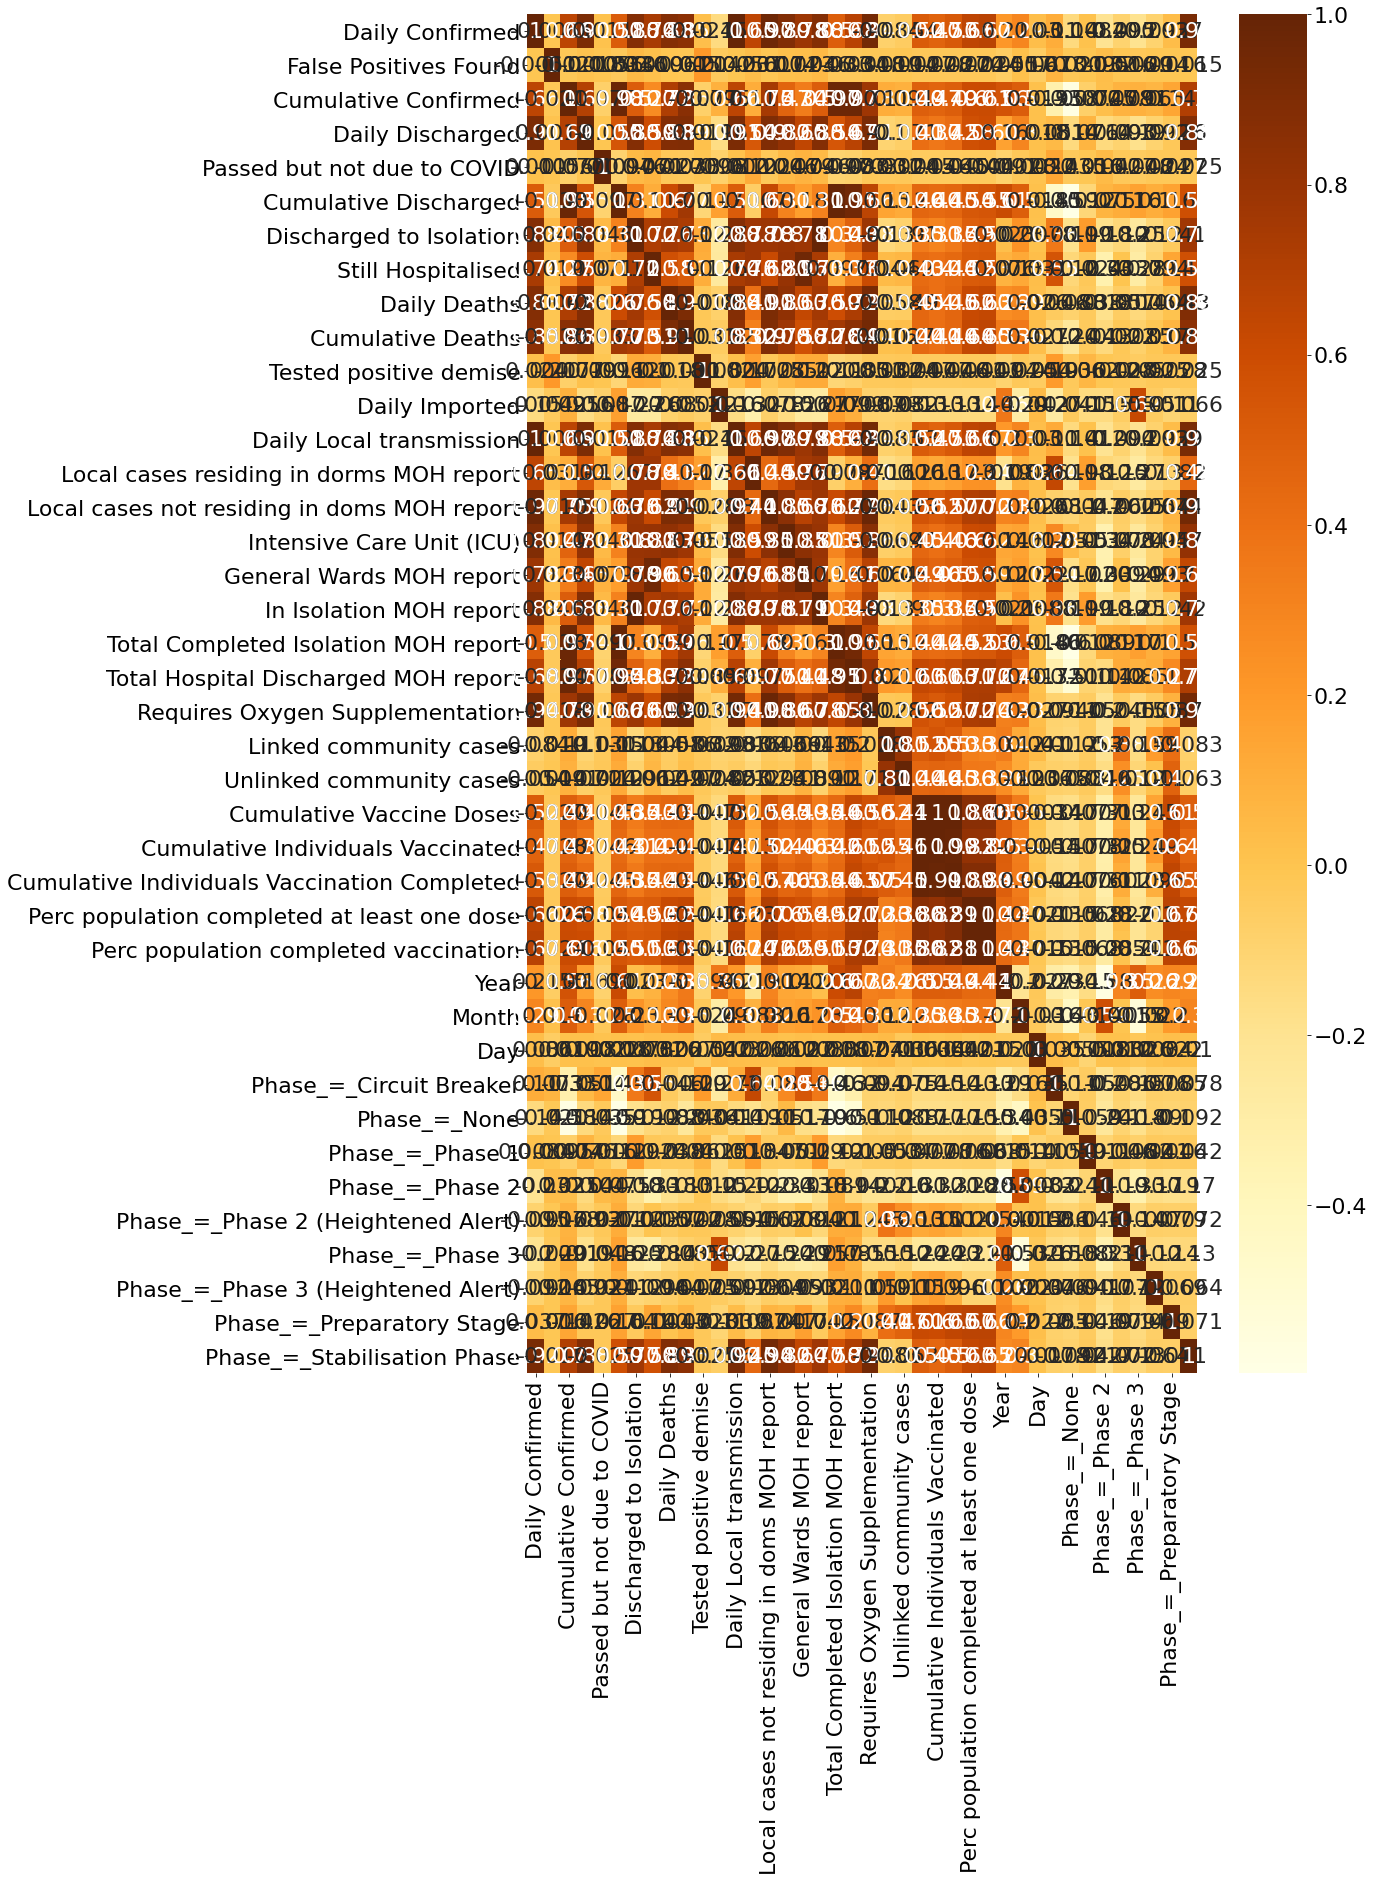

In [59]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [60]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Perc population completed vaccination"].sort_values(ascending=False)

Perc population completed vaccination           1.000000
Perc population completed at least one dose     0.998891
Cumulative Individuals Vaccination Completed    0.884454
Cumulative Vaccine Doses                        0.856603
Cumulative Individuals Vaccinated               0.820757
Requires Oxygen Supplementation                 0.737290
Total Hospital Discharged MOH report            0.724670
Local cases not residing in doms MOH report     0.719875
Daily Local transmission                        0.674798
Daily Confirmed                                 0.674367
Phase_=_Preparatory Stage                       0.664563
Cumulative Deaths                               0.653214
Phase_=_Stabilisation Phase                     0.647160
Daily Deaths                                    0.632518
Intensive Care Unit (ICU)                       0.618702
Cumulative Confirmed                            0.612644
Daily Discharged                                0.598536
General Wards MOH report       

# PCA

In [61]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [62]:
# pca.components_[0]

In [63]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [64]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Viewing Chart Pattern

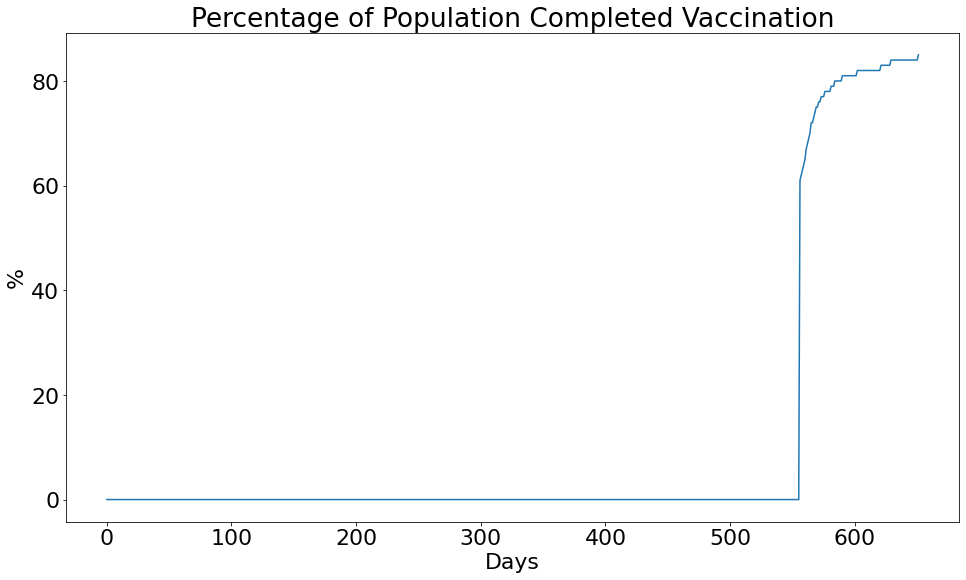

In [65]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Perc population completed vaccination"].plot()
plt.title('Percentage of Population Completed Vaccination')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()
# fig.savefig('Percentage_of_Population_Completed_Vaccination.png')

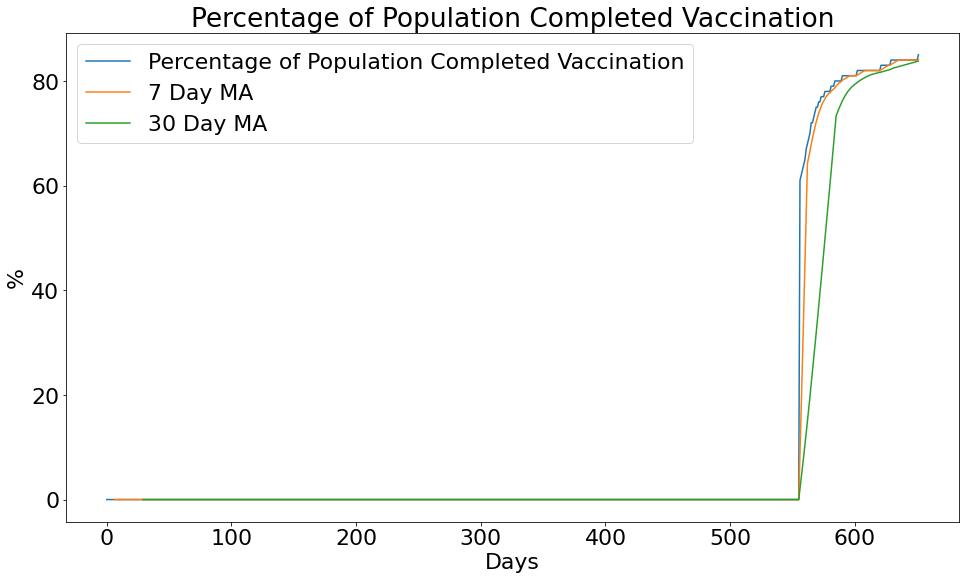

In [66]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Perc population completed vaccination"], label="Percentage of Population Completed Vaccination")
ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Percentage of Population Completed Vaccination')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()
# fig.savefig('Perc_population_completed_vaccination_with_moving_average.png')

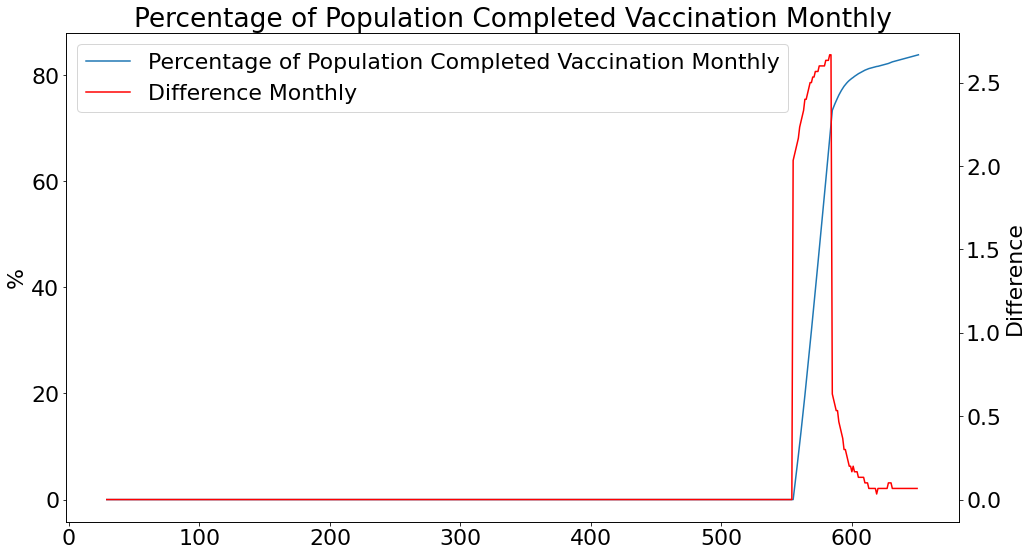

In [67]:
# shows inflection point
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean(), label="Percentage of Population Completed Vaccination Monthly")
ax.set_ylabel("%")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean()), label="Difference Monthly", color="red")
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1 + ln2)])
plt.title('Percentage of Population Completed Vaccination Monthly')
plt.xlabel('Days')
plt.show()
# fig.savefig('Perc_population_completed_vaccination_with_diff.png')

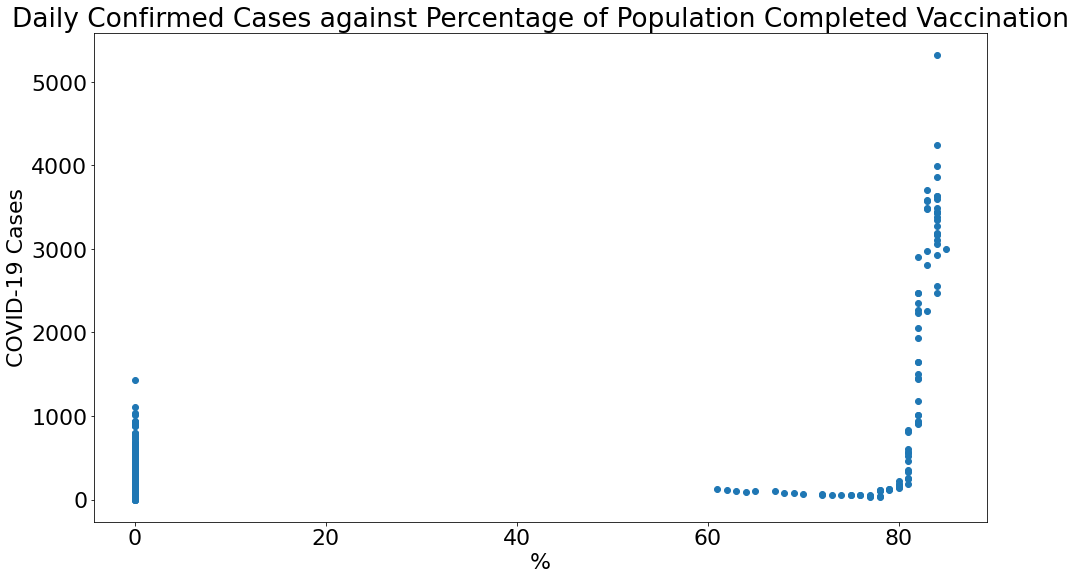

In [68]:
# Shall we use a constant rate of vaccination rate for the data we do not have? - imputation
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Perc population completed vaccination"],sg_data_filtered["Daily Confirmed"])
plt.title('Daily Confirmed Cases against Percentage of Population Completed Vaccination')
plt.xlabel('%')
plt.ylabel('COVID-19 Cases')
plt.show()
# fig.savefig('Perc_population_completed_vaccination_scatter.png')

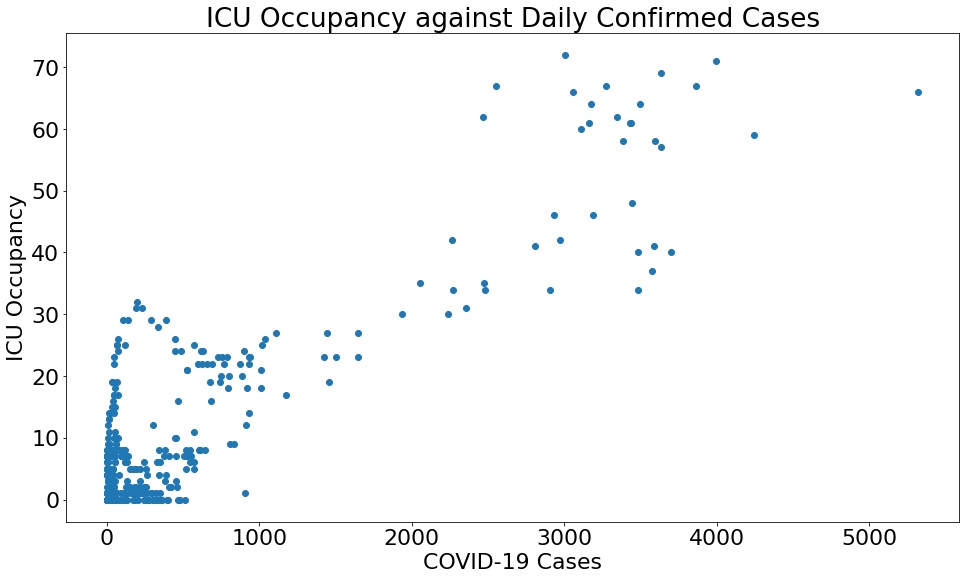

In [69]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Intensive Care Unit (ICU)"])
plt.title('ICU Occupancy against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('ICU Occupancy')
plt.show()
# fig.savefig('ICU_Occupancy_against_Daily_Confirmed_Cases_Scatter.png')

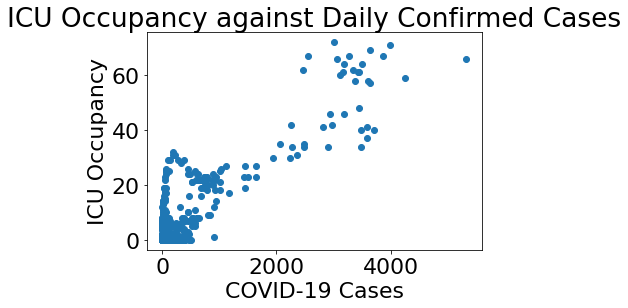

In [70]:
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Intensive Care Unit (ICU)"])
plt.title('ICU Occupancy against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('ICU Occupancy')
plt.show()

## Phases

In [71]:
# fig, ax = plt.subplots(figsize=(16,9))
# sg_data_filtered.groupby('Phase')["Daily Confirmed"].mean().plot.bar()
# plt.title('Average COVID-19 Cases per Phase')
# plt.xlabel('Phases')
# plt.ylabel('Average COVID-19 Cases')
# plt.show()
# fig.savefig('Average_Cases_per_phase.png')

# Train Test Split & K Fold Cross Validation

In [72]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Perc population completed vaccination", axis=1)
y = sg_data_filtered["Perc population completed vaccination"]
y

0       0
1       0
2       0
3       0
4       0
       ..
647    84
648    84
649    84
650    84
651    85
Name: Perc population completed vaccination, Length: 652, dtype: int64

In [73]:
# split using 20% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [74]:
# strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [75]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [76]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 0.2276214856035477
MSE: 0.08931933804900327
RMSE: 0.29886341035497016
R-squared score for train: 0.9998040010297162
Adjusted R-squared score for train: 0.999791510899257
R-squared score for test: 0.9999063136359505
Adjusted R-squared score for test: 0.9999003434264767
Cross Validation Score: 0.9997


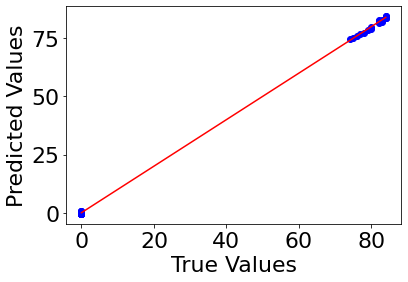

In [77]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

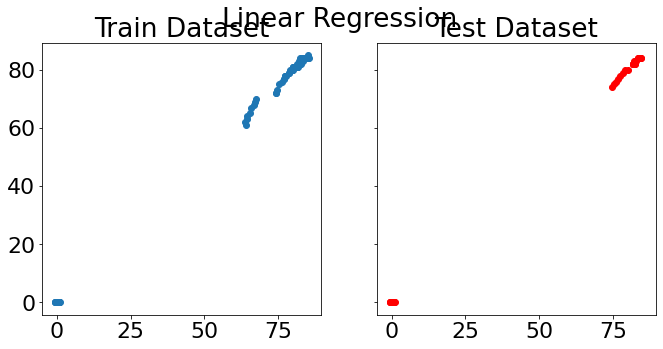

In [78]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [79]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
11,Daily Imported,4.825805e+04
12,Daily Local transmission,4.825805e+04
37,Phase_=_Preparatory Stage,3.692496e+00
38,Phase_=_Stabilisation Phase,3.583207e+00
26,Perc population completed at least one dose,8.172273e-01
6,Discharged to Isolation,1.144663e-01
7,Still Hospitalised,1.143971e-01
9,Cumulative Deaths,1.097975e-01
5,Cumulative Discharged,1.066394e-01
10,Tested positive demise,1.032731e-01


# Ridge Regression

In [80]:
# build lasso model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.8193e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [81]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.26430592580730866
MSE: 0.16297496464224853
RMSE: 0.4037015786967504
R-squared score for train: 0.9997590951446997
Adjusted R-squared score for train: 0.9997437433647051
R-squared score for test: 0.9998290568179082
Adjusted R-squared score for test: 0.9998181633798338
Cross Validation Score: 0.9997


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.8193e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.8901e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.13419e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.13187e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.09375e-17): result may not be accurate.


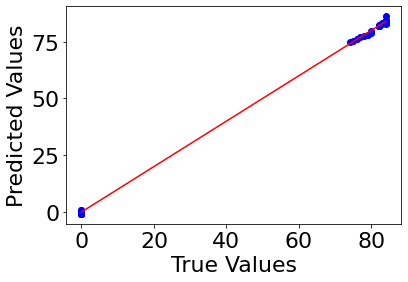

In [82]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

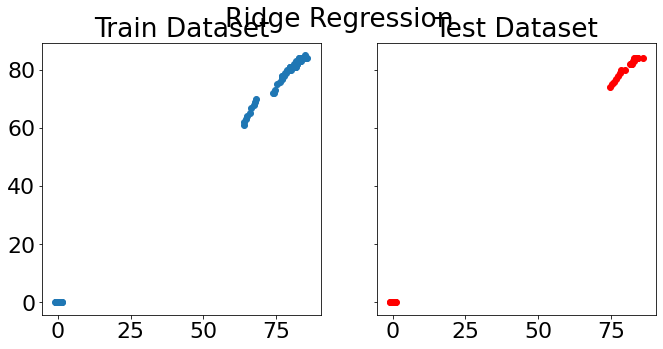

In [83]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [84]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
37,Phase_=_Preparatory Stage,2.592238
38,Phase_=_Stabilisation Phase,1.819917
26,Perc population completed at least one dose,0.810552
9,Cumulative Deaths,0.074889
10,Tested positive demise,0.071447
6,Discharged to Isolation,0.061506
7,Still Hospitalised,0.061360
5,Cumulative Discharged,0.056040
22,Unlinked community cases,0.016303
1,False Positives Found,0.008906


# Ridge Regression Important Features & Future Prediction

In [85]:
# taking out the important features based on the importance level mentioned above as well as necessary features (e.g. Year Day Month)
# add in all the phases
important_X = X[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [86]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [87]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.3175141318374317
MSE: 0.3459050006509508
RMSE: 0.5881368893811634
R-squared score for train: 0.9994609820610847
Adjusted R-squared score for train: 0.9994456545367554
R-squared score for test: 0.9996371829155324
Adjusted R-squared score for test: 0.9996268658420404
Cross Validation Score: 0.9994


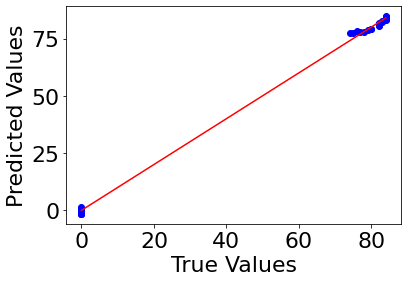

In [88]:
# For test set

# scatter for predictions
plt.scatter(y_test, impt_ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

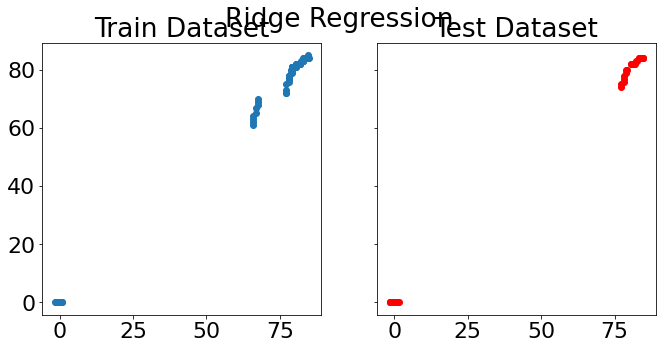

In [89]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(impt_ridge.predict(important_X_train), y_train)
ax[1].scatter(impt_ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

# XGBoost

In [90]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 4,
 'max_depth': 3,
 'colsample_bytree': 0.9}

In [91]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.9, max_depth=4, colsample_bytree=0.7, min_child_weight=4)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 0.06516825951231106
MSE: 0.07604160154957934
RMSE: 0.27575641705965676
R-squared score for train: 0.9999859937138418
Adjusted R-squared score for train: 0.9999855954308231
R-squared score for test: 0.9999202405512481
Adjusted R-squared score for test: 0.9999179725100513
Cross Validation Score: 0.999


# Prediction with XGBoost

In [97]:
future_prediction = pd.DataFrame(data={
    "Perc population completed at least one dose":[90],
    "Tested positive demise":[0],
    "Cumulative Deaths":[600],
    "Discharged to Isolation":[45000],
    "Still Hospitalised":[1800],
    "Cumulative Discharged":[250000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([84.12365], dtype=float32)

In [93]:
xgb_fut_pred
# 84.0% fully vaccinated in SG by 14 Dec 2021


array([81.81968], dtype=float32)